<a href="https://colab.research.google.com/github/aryan-kazuha/ML-DL_projects/blob/main/Eye_disease_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import cv2

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,BatchNormalization
from keras.metrics import Accuracy,Precision,categorical_crossentropy

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

In [ ]:
! pip install opendatasets

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/ruhulaminsharif/eye-disease-image-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: attackonstats
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/ruhulaminsharif/eye-disease-image-dataset


100%|██████████| 3.67G/3.67G [00:33<00:00, 119MB/s]


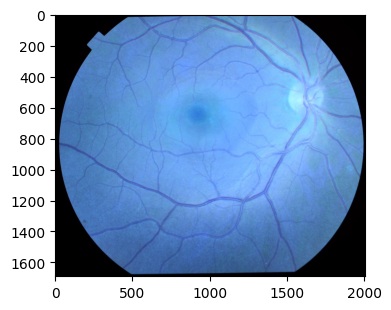

In [ ]:
sample_img = "/content/eye-disease-image-dataset/Augmented Dataset/Augmented Dataset/Central Serous Chorioretinopathy-Color Fundus/CSCR1.jpg"

plt.figure(figsize=(4,4))
plt.imshow(cv2.imread(sample_img))
plt.show()

In [ ]:
root_dir = "/content/eye-disease-image-dataset"

imgs = []
labels = []

for dirpath,dirname,filenames in os.walk(root_dir):
  for filename in filenames:
    if filename.endswith(".jpg"):
      img_path = os.path.join(dirpath,filename)
      class_label = os.path.basename(os.path.dirname(img_path))
      imgs.append(img_path)
      labels.append(class_label)

df = pd.DataFrame({"path":imgs,"label":labels})

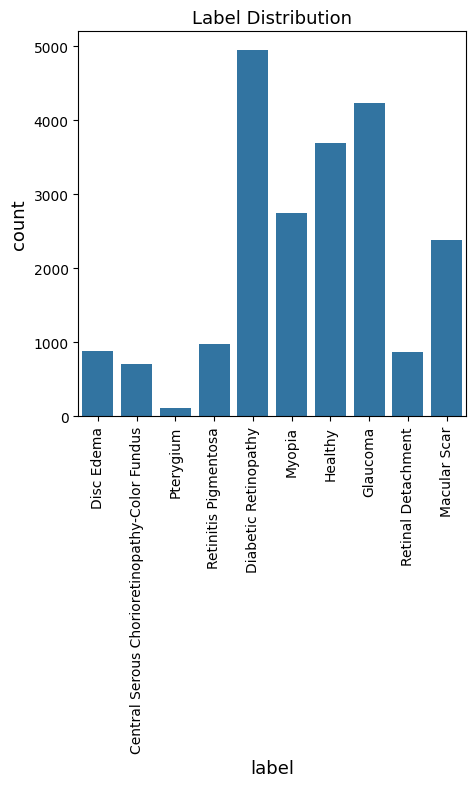

In [ ]:
plt.figure(figsize=(5,5))
sns.countplot(x = df['label'])

plt.xticks(rotation = 90)
plt.xlabel("label",fontsize = 13)
plt.ylabel("count",fontsize = 13)
plt.title("Label Distribution",fontsize = 13)
plt.show()

In [ ]:
unique_labels = df['label'].unique()
label_to_index = {label: i for i, label in enumerate(unique_labels)}

# Map the string labels to numerical indices in the DataFrame
df['label'] = df['label'].map(label_to_index)

In [ ]:
df.head()

,path,label
0,/content/eye-disease-image-dataset/Original Da...,0
1,/content/eye-disease-image-dataset/Original Da...,0
2,/content/eye-disease-image-dataset/Original Da...,0
3,/content/eye-disease-image-dataset/Original Da...,0
4,/content/eye-disease-image-dataset/Original Da...,0


In [ ]:
print(f"Number of images: {len(df)}")

Number of images: 21577


In [ ]:
X_train1,X_test,y_train1,y_test = train_test_split(df['path'],df['label'],test_size =0.2,random_state=42,stratify= df['label'])
X_train,X_val,y_train,y_val = train_test_split(X_train1,y_train1,test_size =0.25,random_state=42,stratify= y_train1)

In [ ]:
def preprocess(img_path,labels):
  image = tf.io.read_file(img_path)
  image = tf.image.decode_jpeg(image,channels=3)
  image = tf.image.resize(image,(224,224))
  image = tf.cast(image,tf.float32) /255.
  labels = tf.one_hot(labels,depth = 10)

  return image,labels


In [ ]:
train_data = tf.data.Dataset.from_tensor_slices((X_train,y_train))
test_data = tf.data.Dataset.from_tensor_slices((X_test,y_test))
val_data = tf.data.Dataset.from_tensor_slices((X_val,y_val))

In [ ]:
train_data = train_data.map(preprocess,num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.map(preprocess,num_parallel_calls=tf.data.AUTOTUNE)
val_data = val_data.map(preprocess,num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
BATCH_SIZE = 32

train_data = train_data.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_data   = test_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_data  = val_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
model = Sequential()
model.add(Conv2D(32,kernel_size=(3,3),padding="valid",activation = "relu",input_shape = (224,224,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides = 2,padding = "valid"))

model.add(Conv2D(32,kernel_size=(3,3),padding="valid",activation = "relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides = 2,padding = "valid"))

model.add(Conv2D(32,kernel_size=(3,3),padding="valid",activation = "relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides = 2,padding = "valid"))

model.add(Flatten())

model.add(Dense(128,activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(64,activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(10,activation = 'softmax'))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(
    optimizer = 'adam',
    loss = "categorical_crossentropy",
    metrics = ["accuracy"]
)

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,769,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,797,706 (10.67 MB)

 Trainable params: 2,797,514 (10.67 MB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
conv_base = VGG16(
    weights = 'imagenet',
    include_top = False,
    input_shape = (224,224,3)
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_layer_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [ ]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [ ]:
model2 = Sequential()

model2.add(conv_base)

model2.add(Flatten())
model2.add(Dense(256,activation='relu'))
model2.add(Dense(10,activation='softmax'))

In [ ]:
model2.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5), # Changed lr to learning_rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

In [ ]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,140,042 (80.64 MB)

 Trainable params: 13,504,778 (51.52 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [ ]:
history = model.fit(train_data,validation_data=val_data,epochs=10)

Epoch 1/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 182s 391ms/step - accuracy: 0.2481 - loss: 2.7212 - val_accuracy: 0.2991 - val_loss: 1.8165
Epoch 2/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 182s 364ms/step - accuracy: 0.2933 - loss: 1.9091 - val_accuracy: 0.3119 - val_loss: 2.3506
Epoch 3/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 159s 372ms/step - accuracy: 0.3158 - loss: 1.8560 - val_accuracy: 0.3329 - val_loss: 1.7642
Epoch 4/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 204s 375ms/step - accuracy: 0.3223 - loss: 1.8054 - val_accuracy: 0.3496 - val_loss: 1.7449
Epoch 5/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 197s 465ms/step - accuracy: 0.3369 - loss: 1.7724 - val_accuracy: 0.2817 - val_loss: 1.9776
Epoch 6/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 153s 358ms/step - accuracy: 0.3416 - loss: 1.7759 - val_accuracy: 0.3455 - val_loss: 2.0397
Epoch 7/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 208s 376ms/step - accuracy: 0.3447 - loss: 1.7415 - val_accuracy: 0.3610 - val_loss: 1.7642
Epoch 8/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 201s 371ms/step - accuracy: 0.3740 -

In [ ]:
history2 = model2.fit(train_data,epochs=10,validation_data=val_data)

Epoch 1/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 206s 444ms/step - accuracy: 0.4084 - loss: 1.6573 - val_accuracy: 0.5623 - val_loss: 1.2190
Epoch 2/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 162s 379ms/step - accuracy: 0.6108 - loss: 1.0977 - val_accuracy: 0.6253 - val_loss: 0.9894
Epoch 3/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 202s 382ms/step - accuracy: 0.6667 - loss: 0.9143 - val_accuracy: 0.6274 - val_loss: 0.9745
Epoch 4/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 168s 397ms/step - accuracy: 0.7076 - loss: 0.7978 - val_accuracy: 0.7217 - val_loss: 0.7747
Epoch 5/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 193s 372ms/step - accuracy: 0.7381 - loss: 0.7163 - val_accuracy: 0.7132 - val_loss: 0.7729
Epoch 6/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 163s 384ms/step - accuracy: 0.7721 - loss: 0.6391 - val_accuracy: 0.6958 - val_loss: 0.8731
Epoch 7/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 208s 394ms/step - accuracy: 0.7912 - loss: 0.5829 - val_accuracy: 0.7296 - val_loss: 0.7218
Epoch 8/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 196s 383ms/step - accuracy: 0.8002 -

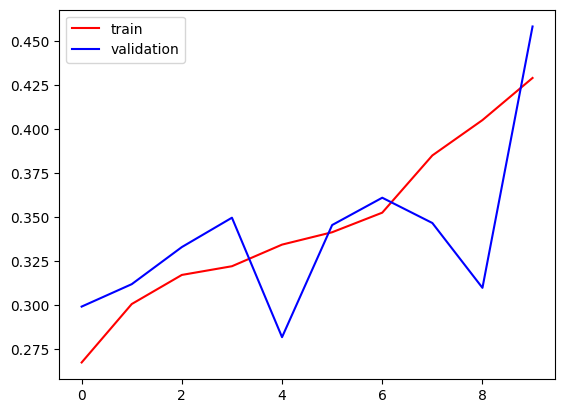

In [ ]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

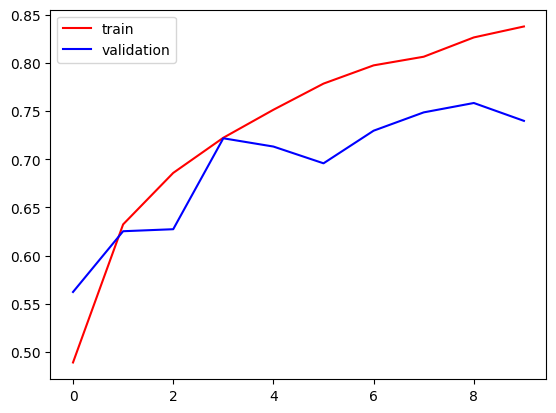

In [ ]:
plt.plot(history2.history['accuracy'],color='red',label='train')
plt.plot(history2.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
acc = model2.evaluate(test_data)
print(f"Test accuracy: {acc[1]}")

135/135 ━━━━━━━━━━━━━━━━━━━━ 44s 321ms/step - accuracy: 0.7229 - loss: 0.7264
Test accuracy: 0.7291473746299744


In [ ]:
model.save("model.keras")
model2.save("model2.keras")